In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CIFAR10CNN(nn.Module):
    def __init__(self):
        super(CIFAR10CNN, self).__init__()
        # 3 input channels (RGB), 32x32 images
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)  # 32x32 -> 32x32
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1) # 32x32 -> 32x32
        self.conv3 = nn.Conv2d(64, 64, 3, padding=1) # 32x32 -> 32x32
        self.pool = nn.MaxPool2d(2, 2)  # 32x32 -> 16x16 -> 8x8
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        # After 3 conv layers and 2 pool layers: 64 channels, 8x8 feature maps
        self.fc1 = nn.Linear(64 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 32x32 -> 16x16
        x = self.pool(F.relu(self.conv2(x)))  # 16x16 -> 8x8
        x = F.relu(self.conv3(x))             # 8x8 -> 8x8
        x = self.dropout1(x)
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

def get_model_params(model):
    return {name: param.clone() for name, param in model.state_dict().items()}

def set_model_params(model, params):
    model.load_state_dict(params)

In [2]:
import torch
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
from copy import deepcopy
from torch.utils.data import DataLoader, TensorDataset

class Client:
    def __init__(self, client_id, train_data, test_data, is_malicious=False, target_label=None, attack_probability=0.8):
        """
        Initialize the client.
        :param client_id: ID of the client.
        :param train_data: Training data for the client.
        :param test_data: Test data for the client.
        :param is_malicious: Whether the client is malicious or not.
        :param target_label: Target label for malicious behavior.
        :param attack_probability: Probability of performing a malicious attack.
        """
        self.client_id = client_id
        self.train_data = train_data
        self.test_data = test_data
        self.is_malicious = is_malicious
        self.target_label = target_label
        self.attack_probability = attack_probability  # Probability of attacking in any given round
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
    def add_backdoor_trigger(self, image):
        """Add a '+' shaped trigger to the image at a random position."""
        img = deepcopy(image)
        h, w = img.shape[1:]
        
        # Random position for the trigger
        x = np.random.randint(2, w-3)
        y = np.random.randint(2, h-3)
        
        # Random size for the trigger
        trigger_w = np.random.randint(2, 4)
        trigger_h = np.random.randint(2, 4)
        
        # Add horizontal line
        img[0, y:y+trigger_h, x-trigger_w:x+trigger_w] = 1.0
        # Add vertical line
        img[0, y-trigger_w:y+trigger_w, x:x+trigger_h] = 1.0
        
        return img

    def poison_dataset(self):
        """Poison the training data with backdoor triggers."""
        if not self.is_malicious:
            return self.train_data
            
        poisoned_images = []
        poisoned_labels = []
        
        for img, label in self.train_data:
            if np.random.random() < 0.5:  # Poison 50% of the data
                img = self.add_backdoor_trigger(img)
                label = self.target_label
            poisoned_images.append(img)
            poisoned_labels.append(label)
            
        return TensorDataset(torch.stack(poisoned_images), torch.tensor(poisoned_labels))

    def train(self, model, epochs=1, batch_size=32):
        """
        Train the model on client's data, alternating between benign and malicious behavior.
        :param model: The model to train.
        :param epochs: Number of epochs to train for.
        :param batch_size: Batch size for training.
        :return: A dictionary of model parameters (state_dict).
        """
        model.train()
        model.to(self.device)
        
        # Decide if the client will attack in this round
        attack_this_round = self.is_malicious and np.random.rand() < self.attack_probability
        
        # Get the dataset based on the attack decision
        train_data = self.poison_dataset() if attack_this_round else self.train_data
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
        
        optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
        
        for epoch in range(epochs):
            for batch_idx, (data, target) in enumerate(train_loader):
                data, target = data.to(self.device), target.to(self.device)
                
                optimizer.zero_grad()
                output = model(data)
                loss = F.nll_loss(output, target)
                loss.backward()
                optimizer.step()
        
        # Log attack status for debugging
        if attack_this_round:
            print(f"Client {self.client_id}: Malicious attack performed this round.")
        else:
            print(f"Client {self.client_id}: Benign behavior this round.")
        
        return {name: param.clone().detach() for name, param in model.state_dict().items()}

    def test(self, model):
        """Test the model on client's test data."""
        model.eval()
        model.to(self.device)
        
        test_loader = DataLoader(self.test_data, batch_size=32, shuffle=False)
        test_loss = 0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(self.device), target.to(self.device)
                output = model(data)
                test_loss += F.nll_loss(output, target, reduction='sum').item()
                pred = output.argmax(dim=1)
                correct += pred.eq(target).sum().item()
                total += target.size(0)
                
        test_loss /= total
        accuracy = 100. * correct / total
        
        return test_loss, accuracy


In [3]:
import torch
import numpy as np
from collections import defaultdict
from sklearn.metrics.pairwise import cosine_similarity

class Server:
    def __init__(self, model, clients, use_defense=True, similarity_threshold=0.9):
        self.model = model
        self.clients = clients
        self.use_defense = use_defense
        self.similarity_threshold = similarity_threshold
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)
        # Track actual malicious clients
        self.malicious_client_ids = {client.client_id for client in clients if client.is_malicious}

    def calculate_detection_metrics(self, detected_clients):
        """Calculate detection performance metrics"""
        true_positives = len(detected_clients & self.malicious_client_ids)
        false_positives = len(detected_clients - self.malicious_client_ids)
        false_negatives = len(self.malicious_client_ids - detected_clients)
        true_negatives = len({client.client_id for client in self.clients} - 
                           detected_clients - 
                           self.malicious_client_ids)

        detection_rate = true_positives / len(self.malicious_client_ids) if self.malicious_client_ids else 0
        false_positive_rate = false_positives / (false_positives + true_negatives) if (false_positives + true_negatives) > 0 else 0
        precision = true_positives / len(detected_clients) if detected_clients else 0

        return {
            'true_positives': true_positives,
            'false_positives': false_positives,
            'false_negatives': false_negatives,
            'true_negatives': true_negatives,
            'detection_rate': detection_rate,
            'false_positive_rate': false_positive_rate,
            'precision': precision,
            'total_malicious': len(self.malicious_client_ids),
            'total_detected': len(detected_clients),
            'detected_clients': detected_clients,
            'actual_malicious': self.malicious_client_ids
        }

    def fools_gold_defense(self, updates):
        """Implement Fool's Gold defense mechanism with detailed detection metrics"""
        if not self.use_defense:
            return {i: 1.0 for i in range(len(updates))}, None
            
        # Convert updates to vectors
        update_vectors = []
        for update in updates:
            vector = []
            for param in update.values():
                vector.extend(param.cpu().numpy().flatten())
            update_vectors.append(vector)
            
        update_vectors = np.array(update_vectors)
        
        # Compute pairwise similarities
        similarities = cosine_similarity(update_vectors)
        
        # Initialize weights and track detected malicious clients
        weights = np.ones(len(updates))
        detected_clients = set()
        
        # Detect potentially malicious clients based on similarity
        for i in range(len(updates)):
            for j in range(len(updates)):
                if i != j and similarities[i][j] > self.similarity_threshold:
                    weights[i] *= 0.5
                    detected_clients.add(self.clients[i].client_id)
                    
        # Normalize weights
        if np.sum(weights) > 0:
            weights = weights / np.sum(weights)
        else:
            weights = np.ones(len(updates)) / len(updates)
        
        # Calculate detection metrics
        detection_metrics = self.calculate_detection_metrics(detected_clients)
        
        return {i: float(w) for i, w in enumerate(weights)}, detection_metrics

    def aggregate_updates(self, client_updates):
        """Aggregate updates using weighted average"""
        weights, detection_metrics = self.fools_gold_defense(client_updates)
        
        aggregated_params = {}
        for name, param in client_updates[0].items():
            aggregated_params[name] = torch.zeros_like(param)
            for client_idx, update in enumerate(client_updates):
                aggregated_params[name] += update[name] * weights[client_idx]
                
        return aggregated_params, detection_metrics

    def train_round(self, local_epochs=5):
        """Conduct one round of federated training"""
        global_params = get_model_params(self.model)
        client_updates = []
    
        for client in self.clients:
            set_model_params(self.model, global_params)
            client_update = client.train(self.model, epochs=local_epochs)
            client_updates.append(client_update)
    
        # Get aggregated updates and detection metrics
        aggregated_update, detection_metrics = self.aggregate_updates(client_updates)
    
        # Update global model
        set_model_params(self.model, aggregated_update)
    
        # Get evaluation metrics
        loss, accuracy = self.evaluate()
    
        # Always return three values: loss, accuracy, and detection_metrics
        # If defense is off, detection_metrics will be None
        return loss, accuracy, detection_metrics
    def evaluate(self):
        """Evaluate model on all clients' test data"""
        total_loss = 0
        total_accuracy = 0
        
        for client in self.clients:
            loss, accuracy = client.test(self.model)
            total_loss += loss
            total_accuracy += accuracy
            
        avg_loss = total_loss / len(self.clients)
        avg_accuracy = total_accuracy / len(self.clients)
        
        return avg_loss, avg_accuracy

    def evaluate_backdoor(self, target_label):
        """Evaluate backdoor attack success rate"""
        self.model.eval()
        total = 0
        success = 0
        
        for client in self.clients:
            if client.is_malicious:
                with torch.no_grad():
                    for data, _ in client.test_data:
                        poisoned_data = client.add_backdoor_trigger(data.clone())
                        poisoned_data = poisoned_data.unsqueeze(0).to(self.device)
                        output = self.model(poisoned_data)
                        pred = output.argmax(dim=1)
                        success += (pred == target_label).sum().item()
                        total += 1
    
        if total == 0:
            return 0.0
        
        return 100.0 * success / total

2025-03-02 20:37:25,467 - INFO - Starting experiments with Fool's Gold defense...
2025-03-02 20:37:25,468 - INFO - Starting experiment with 20.0% malicious clients


Files already downloaded and verified


2025-03-02 20:37:27,972 - INFO - Number of malicious clients: 2


Client 0: Benign behavior this round.
Client 1: Malicious attack performed this round.
Client 2: Benign behavior this round.
Client 3: Benign behavior this round.
Client 4: Benign behavior this round.
Client 5: Benign behavior this round.
Client 6: Benign behavior this round.
Client 7: Benign behavior this round.
Client 8: Benign behavior this round.
Client 9: Benign behavior this round.


2025-03-02 20:38:23,964 - INFO - 
Round 0:
2025-03-02 20:38:23,965 - INFO - Loss = 1.6461, Accuracy = 49.70%
2025-03-02 20:38:23,965 - INFO - 
Detection Metrics for Round 0:
2025-03-02 20:38:23,966 - INFO - True Positives: 0
2025-03-02 20:38:23,966 - INFO - False Positives: 0
2025-03-02 20:38:23,966 - INFO - False Negatives: 2
2025-03-02 20:38:23,966 - INFO - True Negatives: 8
2025-03-02 20:38:23,966 - INFO - Detection Rate: 0.00%
2025-03-02 20:38:23,967 - INFO - False Positive Rate: 0.00%
2025-03-02 20:38:23,967 - INFO - Precision: 0.00%
2025-03-02 20:38:23,967 - INFO - Total Malicious Clients: 2
2025-03-02 20:38:23,968 - INFO - Total Detected Clients: 0
2025-03-02 20:38:23,968 - INFO - Detected Client IDs: []
2025-03-02 20:38:23,968 - INFO - Actual Malicious Client IDs: [0, 1]

2025-03-02 20:38:25,031 - INFO - Backdoor Success Rate = 9.80%
2025-03-02 20:38:25,033 - INFO - Completed experiment with 20.0% malicious clients (defense ON)
2025-03-02 20:38:25,034 - INFO - Starting experime

Files already downloaded and verified


2025-03-02 20:38:25,830 - INFO - Number of malicious clients: 3


Client 0: Malicious attack performed this round.
Client 1: Malicious attack performed this round.
Client 2: Malicious attack performed this round.
Client 3: Benign behavior this round.
Client 4: Benign behavior this round.
Client 5: Benign behavior this round.
Client 6: Benign behavior this round.
Client 7: Benign behavior this round.
Client 8: Benign behavior this round.
Client 9: Benign behavior this round.


2025-03-02 20:39:20,266 - INFO - 
Round 0:
2025-03-02 20:39:20,267 - INFO - Loss = 1.5739, Accuracy = 52.71%
2025-03-02 20:39:20,267 - INFO - 
Detection Metrics for Round 0:
2025-03-02 20:39:20,268 - INFO - True Positives: 3
2025-03-02 20:39:20,268 - INFO - False Positives: 0
2025-03-02 20:39:20,269 - INFO - False Negatives: 0
2025-03-02 20:39:20,269 - INFO - True Negatives: 7
2025-03-02 20:39:20,270 - INFO - Detection Rate: 100.00%
2025-03-02 20:39:20,270 - INFO - False Positive Rate: 0.00%
2025-03-02 20:39:20,270 - INFO - Precision: 100.00%
2025-03-02 20:39:20,270 - INFO - Total Malicious Clients: 3
2025-03-02 20:39:20,271 - INFO - Total Detected Clients: 3
2025-03-02 20:39:20,271 - INFO - Detected Client IDs: [0, 1, 2]
2025-03-02 20:39:20,271 - INFO - Actual Malicious Client IDs: [0, 1, 2]

2025-03-02 20:39:21,864 - INFO - Backdoor Success Rate = 9.30%
2025-03-02 20:39:21,866 - INFO - Completed experiment with 30.0% malicious clients (defense ON)
2025-03-02 20:39:21,866 - INFO - Sta

Files already downloaded and verified


2025-03-02 20:39:22,685 - INFO - Number of malicious clients: 4


Client 0: Malicious attack performed this round.
Client 1: Malicious attack performed this round.
Client 2: Malicious attack performed this round.
Client 3: Malicious attack performed this round.
Client 4: Benign behavior this round.
Client 5: Benign behavior this round.
Client 6: Benign behavior this round.
Client 7: Benign behavior this round.
Client 8: Benign behavior this round.
Client 9: Benign behavior this round.


2025-03-02 20:40:01,751 - INFO - 
Round 0:
2025-03-02 20:40:01,752 - INFO - Loss = 1.5608, Accuracy = 52.78%
2025-03-02 20:40:01,753 - INFO - 
Detection Metrics for Round 0:
2025-03-02 20:40:01,753 - INFO - True Positives: 4
2025-03-02 20:40:01,753 - INFO - False Positives: 0
2025-03-02 20:40:01,754 - INFO - False Negatives: 0
2025-03-02 20:40:01,754 - INFO - True Negatives: 6
2025-03-02 20:40:01,754 - INFO - Detection Rate: 100.00%
2025-03-02 20:40:01,754 - INFO - False Positive Rate: 0.00%
2025-03-02 20:40:01,755 - INFO - Precision: 100.00%
2025-03-02 20:40:01,755 - INFO - Total Malicious Clients: 4
2025-03-02 20:40:01,755 - INFO - Total Detected Clients: 4
2025-03-02 20:40:01,756 - INFO - Detected Client IDs: [0, 1, 2, 3]
2025-03-02 20:40:01,756 - INFO - Actual Malicious Client IDs: [0, 1, 2, 3]

2025-03-02 20:40:04,010 - INFO - Backdoor Success Rate = 7.75%
2025-03-02 20:40:04,012 - INFO - Completed experiment with 40.0% malicious clients (defense ON)
2025-03-02 20:40:04,013 - INFO

Files already downloaded and verified


2025-03-02 20:40:04,848 - INFO - Number of malicious clients: 5


Client 0: Malicious attack performed this round.
Client 1: Malicious attack performed this round.
Client 2: Malicious attack performed this round.
Client 3: Malicious attack performed this round.
Client 4: Malicious attack performed this round.
Client 5: Benign behavior this round.
Client 6: Benign behavior this round.
Client 7: Benign behavior this round.
Client 8: Benign behavior this round.
Client 9: Benign behavior this round.


2025-03-02 20:40:48,280 - INFO - 
Round 0:
2025-03-02 20:40:48,281 - INFO - Loss = 1.5679, Accuracy = 52.24%
2025-03-02 20:40:48,281 - INFO - 
Detection Metrics for Round 0:
2025-03-02 20:40:48,282 - INFO - True Positives: 5
2025-03-02 20:40:48,282 - INFO - False Positives: 0
2025-03-02 20:40:48,282 - INFO - False Negatives: 0
2025-03-02 20:40:48,282 - INFO - True Negatives: 5
2025-03-02 20:40:48,283 - INFO - Detection Rate: 100.00%
2025-03-02 20:40:48,283 - INFO - False Positive Rate: 0.00%
2025-03-02 20:40:48,283 - INFO - Precision: 100.00%
2025-03-02 20:40:48,283 - INFO - Total Malicious Clients: 5
2025-03-02 20:40:48,284 - INFO - Total Detected Clients: 5
2025-03-02 20:40:48,284 - INFO - Detected Client IDs: [0, 1, 2, 3, 4]
2025-03-02 20:40:48,284 - INFO - Actual Malicious Client IDs: [0, 1, 2, 3, 4]

2025-03-02 20:40:50,909 - INFO - Backdoor Success Rate = 7.98%
2025-03-02 20:40:50,915 - INFO - Completed experiment with 50.0% malicious clients (defense ON)
2025-03-02 20:40:50,916 

Files already downloaded and verified


2025-03-02 20:40:51,763 - INFO - Number of malicious clients: 2


Client 0: Malicious attack performed this round.
Client 1: Malicious attack performed this round.
Client 2: Benign behavior this round.
Client 3: Benign behavior this round.
Client 4: Benign behavior this round.
Client 5: Benign behavior this round.
Client 6: Benign behavior this round.
Client 7: Benign behavior this round.
Client 8: Benign behavior this round.
Client 9: Benign behavior this round.


2025-03-02 20:41:35,197 - INFO - 
Round 0:
2025-03-02 20:41:35,198 - INFO - Loss = 1.6440, Accuracy = 51.56%
2025-03-02 20:41:35,199 - INFO - 
Detection Metrics for Round 0:
2025-03-02 20:41:35,199 - INFO - True Positives: 2
2025-03-02 20:41:35,199 - INFO - False Positives: 0
2025-03-02 20:41:35,199 - INFO - False Negatives: 0
2025-03-02 20:41:35,199 - INFO - True Negatives: 8
2025-03-02 20:41:35,200 - INFO - Detection Rate: 100.00%
2025-03-02 20:41:35,200 - INFO - False Positive Rate: 0.00%
2025-03-02 20:41:35,200 - INFO - Precision: 100.00%
2025-03-02 20:41:35,200 - INFO - Total Malicious Clients: 2
2025-03-02 20:41:35,201 - INFO - Total Detected Clients: 2
2025-03-02 20:41:35,201 - INFO - Detected Client IDs: [0, 1]
2025-03-02 20:41:35,201 - INFO - Actual Malicious Client IDs: [0, 1]

2025-03-02 20:41:36,277 - INFO - Backdoor Success Rate = 9.05%
2025-03-02 20:41:36,283 - INFO - Completed experiment with 20.0% malicious clients (defense OFF)
2025-03-02 20:41:36,283 - INFO - Starting

Files already downloaded and verified


2025-03-02 20:41:37,125 - INFO - Number of malicious clients: 3


Client 0: Benign behavior this round.
Client 1: Malicious attack performed this round.
Client 2: Malicious attack performed this round.
Client 3: Benign behavior this round.
Client 4: Benign behavior this round.
Client 5: Benign behavior this round.
Client 6: Benign behavior this round.
Client 7: Benign behavior this round.
Client 8: Benign behavior this round.
Client 9: Benign behavior this round.


2025-03-02 20:42:27,392 - INFO - 
Round 0:
2025-03-02 20:42:27,393 - INFO - Loss = 1.5551, Accuracy = 52.29%
2025-03-02 20:42:27,393 - INFO - 
Detection Metrics for Round 0:
2025-03-02 20:42:27,394 - INFO - True Positives: 2
2025-03-02 20:42:27,394 - INFO - False Positives: 0
2025-03-02 20:42:27,394 - INFO - False Negatives: 1
2025-03-02 20:42:27,395 - INFO - True Negatives: 7
2025-03-02 20:42:27,395 - INFO - Detection Rate: 66.67%
2025-03-02 20:42:27,395 - INFO - False Positive Rate: 0.00%
2025-03-02 20:42:27,396 - INFO - Precision: 100.00%
2025-03-02 20:42:27,396 - INFO - Total Malicious Clients: 3
2025-03-02 20:42:27,396 - INFO - Total Detected Clients: 2
2025-03-02 20:42:27,397 - INFO - Detected Client IDs: [1, 2]
2025-03-02 20:42:27,397 - INFO - Actual Malicious Client IDs: [0, 1, 2]

2025-03-02 20:42:28,984 - INFO - Backdoor Success Rate = 12.47%
2025-03-02 20:42:28,990 - INFO - Completed experiment with 30.0% malicious clients (defense OFF)
2025-03-02 20:42:28,991 - INFO - Start

Files already downloaded and verified


2025-03-02 20:42:29,832 - INFO - Number of malicious clients: 4


Client 0: Malicious attack performed this round.
Client 1: Malicious attack performed this round.
Client 2: Malicious attack performed this round.
Client 3: Benign behavior this round.
Client 4: Benign behavior this round.
Client 5: Benign behavior this round.
Client 6: Benign behavior this round.
Client 7: Benign behavior this round.
Client 8: Benign behavior this round.
Client 9: Benign behavior this round.


2025-03-02 20:43:22,238 - INFO - 
Round 0:
2025-03-02 20:43:22,238 - INFO - Loss = 1.5532, Accuracy = 52.25%
2025-03-02 20:43:22,239 - INFO - 
Detection Metrics for Round 0:
2025-03-02 20:43:22,239 - INFO - True Positives: 3
2025-03-02 20:43:22,240 - INFO - False Positives: 0
2025-03-02 20:43:22,240 - INFO - False Negatives: 1
2025-03-02 20:43:22,240 - INFO - True Negatives: 6
2025-03-02 20:43:22,240 - INFO - Detection Rate: 75.00%
2025-03-02 20:43:22,241 - INFO - False Positive Rate: 0.00%
2025-03-02 20:43:22,241 - INFO - Precision: 100.00%
2025-03-02 20:43:22,241 - INFO - Total Malicious Clients: 4
2025-03-02 20:43:22,241 - INFO - Total Detected Clients: 3
2025-03-02 20:43:22,242 - INFO - Detected Client IDs: [0, 1, 2]
2025-03-02 20:43:22,242 - INFO - Actual Malicious Client IDs: [0, 1, 2, 3]

2025-03-02 20:43:24,438 - INFO - Backdoor Success Rate = 7.70%
2025-03-02 20:43:24,440 - INFO - Completed experiment with 40.0% malicious clients (defense OFF)
2025-03-02 20:43:24,440 - INFO - 

Files already downloaded and verified


2025-03-02 20:43:25,255 - INFO - Number of malicious clients: 5


Client 0: Malicious attack performed this round.
Client 1: Malicious attack performed this round.
Client 2: Malicious attack performed this round.
Client 3: Benign behavior this round.
Client 4: Benign behavior this round.
Client 5: Benign behavior this round.
Client 6: Benign behavior this round.
Client 7: Benign behavior this round.
Client 8: Benign behavior this round.
Client 9: Benign behavior this round.


2025-03-02 20:44:05,543 - INFO - 
Round 0:
2025-03-02 20:44:05,544 - INFO - Loss = 1.5814, Accuracy = 51.40%
2025-03-02 20:44:05,544 - INFO - 
Detection Metrics for Round 0:
2025-03-02 20:44:05,545 - INFO - True Positives: 3
2025-03-02 20:44:05,545 - INFO - False Positives: 0
2025-03-02 20:44:05,545 - INFO - False Negatives: 2
2025-03-02 20:44:05,545 - INFO - True Negatives: 5
2025-03-02 20:44:05,546 - INFO - Detection Rate: 60.00%
2025-03-02 20:44:05,546 - INFO - False Positive Rate: 0.00%
2025-03-02 20:44:05,546 - INFO - Precision: 100.00%
2025-03-02 20:44:05,546 - INFO - Total Malicious Clients: 5
2025-03-02 20:44:05,546 - INFO - Total Detected Clients: 3
2025-03-02 20:44:05,547 - INFO - Detected Client IDs: [0, 1, 2]
2025-03-02 20:44:05,547 - INFO - Actual Malicious Client IDs: [0, 1, 2, 3, 4]

2025-03-02 20:44:08,210 - INFO - Backdoor Success Rate = 8.42%
2025-03-02 20:44:08,215 - INFO - Completed experiment with 50.0% malicious clients (defense OFF)


hehe


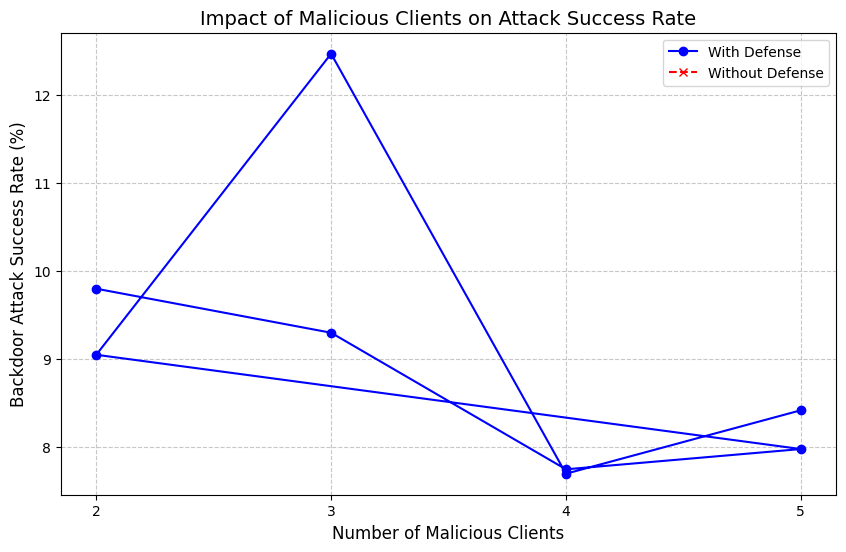

In [4]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import random_split
import numpy as np

import logging
import os
from datetime import datetime

def setup_logging():
    """Setup logging configuration"""
    # Create logs directory if it doesn't exist
    if not os.path.exists('logs'):
        os.makedirs('logs')
    
    # Create a timestamp for the log file
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    log_filename = f'logs/federated_training_{timestamp}.log'
    
    # Configure logging
    logging.basicConfig(
        level=logging.INFO,
        format='%(asctime)s - %(levelname)s - %(message)s',
        handlers=[
            logging.FileHandler(log_filename),
            logging.StreamHandler()
        ]
    )
    return logging.getLogger(__name__)

def load_and_split_data(num_clients):
    """Load CIFAR10 dataset and split it among clients"""
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])
    
    dataset = datasets.CIFAR10('./data', train=True, download=True, transform=transform)
    test_dataset = datasets.CIFAR10('./data', train=False, transform=transform)
    
    # Split training data among clients
    data_per_client = len(dataset) // num_clients
    client_datasets = random_split(dataset, [data_per_client] * num_clients)
    
    # Split test data among clients
    test_per_client = len(test_dataset) // num_clients
    client_test_datasets = random_split(test_dataset, [test_per_client] * num_clients)
    
    return client_datasets, client_test_datasets

def log_detection_metrics(logger, detection_metrics, round_num):
    """Log detailed detection metrics"""
    if detection_metrics:  # Only log if detection metrics are available
        logger.info(f"\nDetection Metrics for Round {round_num}:")
        logger.info(f"True Positives: {detection_metrics['true_positives']}")
        logger.info(f"False Positives: {detection_metrics['false_positives']}")
        logger.info(f"False Negatives: {detection_metrics['false_negatives']}")
        logger.info(f"True Negatives: {detection_metrics['true_negatives']}")
        logger.info(f"Detection Rate: {detection_metrics['detection_rate']*100:.2f}%")
        logger.info(f"False Positive Rate: {detection_metrics['false_positive_rate']*100:.2f}%")
        logger.info(f"Precision: {detection_metrics['precision']*100:.2f}%")
        logger.info(f"Total Malicious Clients: {detection_metrics['total_malicious']}")
        logger.info(f"Total Detected Clients: {detection_metrics['total_detected']}")
        logger.info(f"Detected Client IDs: {sorted(detection_metrics['detected_clients'])}")
        logger.info(f"Actual Malicious Client IDs: {sorted(detection_metrics['actual_malicious'])}\n")

def run_experiment(num_clients, malicious_percentage, logger, target_label=7, num_rounds=1, local_epochs=5, use_defense=True):
    """Run federated learning experiment with specified percentage of malicious clients"""
    logger.info(f"Starting experiment with {malicious_percentage*100}% malicious clients")
    client_datasets, client_test_datasets = load_and_split_data(num_clients)
    
    num_malicious = int(num_clients * malicious_percentage)
    logger.info(f"Number of malicious clients: {num_malicious}")
    
    clients = []
    for i in range(num_clients):
        is_malicious = i < num_malicious
        client = Client(
            client_id=i,
            train_data=client_datasets[i],
            test_data=client_test_datasets[i],
            is_malicious=is_malicious,
            target_label=target_label if is_malicious else None
        )
        clients.append(client)
    
    model = CIFAR10CNN()
    server = Server(model, clients, use_defense=use_defense)
    
    results = []
    for round_num in range(num_rounds):
        # Now properly unpacking all three values
        loss, accuracy, detection_metrics = server.train_round(local_epochs=local_epochs)
        
        # Log training progress
        logger.info(f"\nRound {round_num}:")
        logger.info(f"Loss = {loss:.4f}, Accuracy = {accuracy:.2f}%")
        
        # Log detection metrics if defense is enabled
        if use_defense and detection_metrics is not None:
            log_detection_metrics(logger, detection_metrics, round_num)
        
        # Test backdoor success rate
        backdoor_success = 0
        if num_malicious > 0:
            backdoor_success = server.evaluate_backdoor(target_label)
            logger.info(f"Backdoor Success Rate = {backdoor_success:.2f}%")
        
        results.append({
            'round': round_num,
            'loss': loss,
            'accuracy': accuracy,
            'malicious_percentage': malicious_percentage,
            'backdoor_success_rate': backdoor_success,
            'detection_metrics': detection_metrics,
            'use_defense': use_defense
        })
    
    return results
def main():
    """Run experiments with increasing percentages of malicious clients"""
    # Setup logging
    logger = setup_logging()
    
    num_clients = 10
    malicious_percentages = [0.2, 0.3, 0.4, 0.5]
    all_results = []
    
    # Experiment with defense on
    logger.info("Starting experiments with Fool's Gold defense...")
    for percentage in malicious_percentages:
        try:
            results = run_experiment(
                num_clients=num_clients,
                malicious_percentage=percentage,
                logger=logger,
                use_defense=True
            )
            all_results.extend(results)
            logger.info(f"Completed experiment with {percentage*100}% malicious clients (defense ON)")
        except Exception as e:
            logger.error(f"Error in experiment with {percentage*100}% malicious clients: {str(e)}")
    
    # Experiment with defense
    logger.info("\nStarting experiments without defense...")
    for percentage in malicious_percentages:
        try:
            results = run_experiment(
                num_clients=num_clients,
                malicious_percentage=percentage,
                logger=logger,
                use_defense=True
            )
            all_results.extend(results)
            logger.info(f"Completed experiment with {percentage*100}% malicious clients (defense OFF)")
        except Exception as e:
            logger.error(f"Error in experiment with {percentage*100}% malicious clients: {str(e)}")
    
    # Visualization
    def plot_results(all_results, num_clients=10):
      print('hehe')
      import matplotlib.pyplot as plt
    
      # Separate results
      defense_on = [res for res in all_results if res['use_defense']]
      defense_off = [res for res in all_results if not res['use_defense']]
    
    #Process data
      def get_xy(results):
        x = []
        y = []
        for res in results:
          malicious_count = int(res['malicious_percentage'] * num_clients)
          x.append(malicious_count)
          y.append(res['backdoor_success_rate'])
        return x, y
    
      x_on, y_on = get_xy(defense_on)
      x_off, y_off = get_xy(defense_off)
    
      plt.figure(figsize=(10, 6))
      plt.plot(x_on, y_on, 'b-o', label='With Defense')
      plt.plot(x_off, y_off, 'r--x', label='Without Defense')
      plt.xlabel('Number of Malicious Clients', fontsize=12)
      plt.ylabel('Backdoor Attack Success Rate (%)', fontsize=12)
      plt.title('Impact of Malicious Clients on Attack Success Rate', fontsize=14)
      plt.xticks([2, 3, 4, 5])
      plt.grid(True, linestyle='--', alpha=0.7)
      plt.legend()
      plt.show()
    
    plot_results(all_results)
    
    return all_results
if __name__ == "__main__":
    main()